## Import packages

In [ ]:
import CairoMakie: activate!, Figure, Axis, save, lines!, scatter!, lines, scatter, scatterlines!, 
hlines!, vlines!, axislegend, Legend, series, series!, Theme, set_theme!, cgrad, band!, 
xlims!, ylims!, stem!, arrows!, hist!, errorbars!, xticks!, save, text!, 
GridLayout, contourf!, Colorbar,  hist!, contour!, heatmap!, image!, density!, tightlimits!, 
poly!, hidedecorations!, hidexdecorations!, hideydecorations!, hidespines!, Label, text!, colgap!, rowgap!, 
Outside, colsize!, rowsize!, Relative, AxisAspect, Inside, Relative, rowsize!, colsize!, Outside,
poly!, hidedecorations!, hidespines!, Label, text!, AxisAspect, GridLayout, Outside, colsize!, rowsize!, Relative, AxisAspect, 
density!, qqplot!, linkxaxes!, linkyaxes!, BBox, translate!, TopLeft, Label, resize_to_layout!,
hidexdecorations!, hideydecorations!, Inside, Outside, Aspect, Observable, notify, colgap!, rowgap!
import Makie.GeometryBasics: Rect, Point2f
import Makie: get_ticklabels
import Measures: mm
import Roots: find_zero, fzero, newton, Newton
import CurveFit: curve_fit, Polynomial, ExpFit, LogFit, PowerFit, KingFit, LinearKingFit, LinearFit, RationalPoly
import Calculus: derivative
import StatsBase: sample, mean, min, mode, max
import BasicInterpolators: CubicSplineInterpolator, CubicInterpolator, LinearInterpolator
import CSV: write, File
import DataFrames: DataFrame
import Distributed: addprocs, pmap, @everywhere
import Dates: now, Millisecond
using LaTeXStrings
import ProgressMeter: @showprogress
import NLsolve: nlsolve
import Roots: find_zero, fzero, newton, Newton
import Plots: palette
c=palette(:default); c = [palette(:tab10)[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
colblue=palette(:default)[1];
#c=palette(:tab10); c = [c[1]; c[3]; c[4];c[5]; c[2]; [c[i] for i in 6:length(c)]]; #reorder colors
activate!() #activates the Makie backend
set_theme!(Theme(
    palette  = (color = cgrad(c,length(c)),),
    Lines    = (cycle = [:color],), 
    band     = (cycle = [:color],),
    hlines   = (cycle = [:color],),
    vlines   = (cycle = [:color],),
    scatter  = (cycle = [:color],),
    scatterlines = (cycle = [:color],),
    series   = (cycle = [:color],),
    colormap = cgrad(:default),   #sunset,    # CMRmap  gnuplot magma plasma   thermal   linear_bmy_10_95_c78_n256 linear_bmy_10_95_c71_n256
    #Axis=(yticklabelsize=18, xticklabelsize=18,xlabelsize=20,ylabelsize=20),
    #Axis=(titlesize=24,),
    ))
#ax[1].xticklabelrotation=45.0
#ax[1].xtickformat = "{:.1f}"

findnearest(t, A::AbstractArray) = findmin(abs.(A.-t))[2];
findnearest(vec::AbstractArray, A::AbstractArray) = findnearest.(vec, Ref(A));

# Phase diagram

In [2]:
dT = 0.001; Tblue_max = 0.5;
Tblue = dT:dT:Tblue_max;
Fblue(T) = T*acosh((1-T)/T);
ηblue = Fblue.(Tblue);
Tbluemax = Tblue[findmax(ηblue)[2]]; ηbluemax = findmax(ηblue)[1];

findnearest(t, A::AbstractArray) = findmin(abs.(A.-t))[2];
findnearest(vec::AbstractArray, A::AbstractArray) = findnearest.(vec, Ref(A));

nanlength(x::AbstractArray) = sum(.~isnan.(x));
nanse(x::AbstractArray) = nanstd(x) / sqrt(nanlength(x));

function find_redline(T)  
    fv(T, η, v) = -v + 0.5*sinh(2*v/T)/(cosh(2*v/T) + cosh(η/T));
    dfdv_v(T, x) = [fv(T, x[1], x[2])
                    derivative(v -> fv(T, x[1], v), x[2])];
    xguess(T) = [1-T, 0.5 - T/8];
    return T < 0.0029 ? NaN : try nlsolve(x -> dfdv_v(T, x), xguess(T)).zero[1] catch y NaN end
end

## MF equations
FV(    T, η, V) = 1/2*sinh(2*V/T) / (cosh(2*V/T) + cosh(η/T)) - V;
dFdV(  T, η, V) = derivative(V->FV(T, η, V), V)
d2FdV2(T, η, V) = derivative(V->dFdV(T, η, V), V)
d3FdV3(T, η, V) = derivative(V->d2FdV2(T, η, V), V)

function find_3crit_point()
    #T, eta, V
    find_3crit(x) = [FV(x[1], x[2], x[3]), dFdV(x[1], x[2], x[3]), d3FdV3(x[1], x[2], x[3])];
    xguess = [0.32, Fblue(0.32), 0];
    critpoint = nlsolve(x -> find_3crit(x), xguess).zero;  
    Tcritpoint=critpoint[1]; ηcritpoint=critpoint[2]; Vcritpoint=critpoint[3];
    return Tcritpoint, ηcritpoint
end
function find_redline_full(Tred)
    Tcritpoint = find_3crit_point()[1];
    dV_redcrit = 10^(-2);
    #red line
    dfdv_v_redcritline(T, x) = [FV(T, x[1], x[2]), dFdV(T, x[1], x[2])];
    xguess_redcritline1(T) = [find_redline(T), 0.5 - T/8];
    xsol = [nlsolve(x -> dfdv_v_redcritline(T, x), xguess_redcritline1(T)).zero for T in Tred];
    etasol = [el[1] for el in xsol];   vsol = [el[2] for el in xsol];  Tsol = Tred; 
    Tsol, etasol, vsol = Tsol[vsol .> dV_redcrit], etasol[vsol .> dV_redcrit], vsol[vsol .> dV_redcrit];
    xguess_redcritline(T) = [find_redline(T), vsol[findnearest(T, Tsol)]];
    xsol = [nlsolve(x -> dfdv_v_redcritline(T, x), xguess_redcritline(T)).zero for T in Tred];
    etasol = [el[1] for el in xsol];   vsol = [el[2] for el in xsol];
    ηred = etasol;
    return ηred
end

Tcritpoint, ηcritpoint = find_3crit_point()
Tred = Tblue[0.003 .≤ Tblue .≤ Tcritpoint];
ηred = find_redline_full(Tred);
Tcritpoint, ηcritpoint 

Tbluemax, ηbluemax, Tred[end], ηred[end]

(0.29, 0.4477431588241105, 0.333, 0.439124328655568)

In [3]:
Tord, Tinterm, Tdisord = 0.3,  0.15, 0.4;
ηord, ηinterm, ηdisord = 0.05, 0.45, 0.6;
phases = ["Ordered phase", "Disordered phase", "Intermittent phase", "Tricritical point"];
T_vec = [Tord, Tdisord, Tinterm, Tbluemax]; 
η_vec = [ηord, ηdisord, ηinterm, ηbluemax];

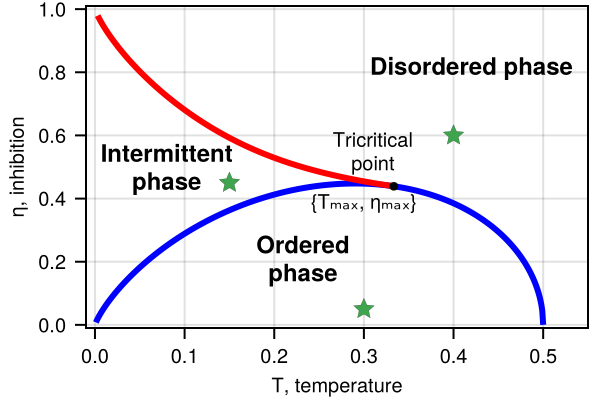

In [4]:
fig = Figure(size=(300, 200), fontsize=10, figure_padding=(3, 6, 3, 3)); ax = []; #400, 300
push!(ax, Axis(fig[1, 1], xlabel="T, temperature", ylabel="η, inhibition"));

lines!(ax[1], Tblue, ηblue, color=:blue, linewidth=3);
lines!(ax[1], Tred,  ηred,  color=:red,  linewidth=3);

scatter!(ax[1], [Tcritpoint],[ηcritpoint], marker=:circle, markersize=6, color=:black, strokewidth=0.1)
scatter!([Tord, Tinterm, Tdisord], [ηord, ηinterm, ηdisord], markersize=12, color=c[2], marker=:star5, strokewidth=0.1)
text!(ax[1], [0.08, 0.232, 0.42], [0.5, 0.21, 0.82], text=["Intermittent\nphase", "Ordered\nphase", "Disordered phase"], color=:black, font=:bold, fontsize=12, align=(:center, :center)) #font=:bold,
#text!(ax[1], [0.12, 0.38, 0.458], [0.07, 0.27, 0.72], text=["Ballistic", "Run-and-\ntumble", "Drift-diffusion"], color=:darkblue, fontsize=18, align=(:center, :center)) #font=:bold,
text!(ax[1], [0.31, 0.3], [0.55, 0.39], text=["Tricritical\npoint", "{Tₘₐₓ, ηₘₐₓ}"], color=:black, fontsize=[10, 10], align=(:center, :center)) #font=:bold,

#axislegend(ax[1], position=:rb);
xlims!(ax[1], [-0.01, 0.55]);  ax[1].xticks = 0:0.1:1;
ylims!(ax[1], [-0.01, 1.01]);  ax[1].yticks = 0:0.2:1;
fig

## V distributions

In [5]:
numprocs = 4;
addprocs(numprocs);

In [6]:
@everywhere begin 
    import Dates: now, Millisecond
    findnearest(t::Number, A::AbstractArray) = findmin(abs.(A.-t))[2]; #find the position of t in A
    findnearest(vec::AbstractArray, A::AbstractArray) = [findmin(abs.(A.-t))[2] for t in vec]; #find the positions of elements of vec in A

    function DecisionTrajectory(T::Number, η::Number, ϵk::AbstractVector, L::Number, numSpins::Int, IC::String,
            x_init::Number, r0::Number, timemax::Number, dLcrossed::Number)
        # T - temperature
        # η - inhibition
        # ϵk - array of biases per target
        # L - threshold
        # numSpins - number of spins in one group (per target)
        # IC - initial condition of the active spins
        # x0 - initial position
        # r0 - units of rate
        # timemax - maximum time of the simulation
        # dLcrossed - distance to cut if finish far away from the target

        ## Initialization
        k = length(ϵk); # number of targets
        Pk = [1; -1]; #directions to the targets
        Vfunc(Nk::AbstractVector) = k==2 ? sum(Nk .* Pk)/(numSpins*k) : error("k is not 2!"); # velocity of the system

        Nk_cur = IC=="ZERO" ? zeros(Int8, k) : (IC=="RAND" ? [rand(1:numSpins) for i = 1:k] : error("IC is not valid!")); #[N1, N2, N3] - VEC kx1 define the current distribution of active spins (ON)
        x = x_init; # current position of the system
        v = Vfunc(Nk_cur); # current velocity of the system
        t = 0.0; # current time of the system
        dtrand = 0.0;
        v_next = v;
        x_prev = x;
        t_prev = t;

        v_seq = Array{Float64, 1}(); # velocities of the system
        push!(v_seq, v); # save the initial velocity of the system
        ## Simulation
        while (abs(x) ≤ L) && (t ≤ timemax)

            v = v_next;
            x_prev = x;
            t_prev = t;

            # on/off rates
            dH = (k .* v .* Pk .- η .+ ϵk);
            rk_on    = r0* (numSpins .- Nk_cur) ./ (1 .+ exp.( -dH/T )); # group 1...k: ++1
            rk_off   = r0* Nk_cur               ./ (1 .+ exp.(  dH/T )); # group 1...k: --1
            rates    = [rk_on; rk_off]; #array of rates for each target
            rate_tot = sum(rates); # total rate

            # choose a group to change and time interval
            rand_flip = 1 - rand(); # get a second random number

            # calculate next step: one spin flip occurs
            event = findfirst(rand_flip .<= cumsum(rates ./ rate_tot)); # find the event
            off_event = Int8(event > k); # determine the sign of the event: on=(ind<=k) or off=(ind>k)
            ind_event = event - k*off_event; # index of the event
            Nk_cur[ind_event] = Nk_cur[ind_event] + (-1)^off_event;

            # calculate the time interval
            rand_time = 1 - rand(); # get a random number for gillespie
            dtrand = (1/rate_tot) * log(1/rand_time); # calculate next time interval dt

            #update velocity and position according to the new spin distributions
            x += v * dtrand; # update the position of the system using previous velocity
            v_next = Vfunc(Nk_cur); # update the velocity of the system
            t += dtrand; # update the current time
            push!(v_seq, v); # save the initial velocity of the system
        end

        #check if the motion finished too far from the threshold L
        if abs(x) - L > L*dLcrossed 
            if sign(x) > 0
                x = L;
                dx = L - x_prev; #> 0
            else
                x = -L;
                dx = -L - x_prev; #<0
            end
            t += -dtrand + dx / v;
        end

        return sign(x), t, v_seq

    end
    DecisionTrajectory(T, η, ϵk, L, numSpins; IC="ZERO", x_init=0.0, r0=1.0, timemax=1e15, dLcrossed=1e-5) = 
    DecisionTrajectory(T, η, ϵk, L, numSpins, IC, x_init, r0, timemax, dLcrossed)
end

In [7]:
function DecisionTrajectory_xvt(T::Number, η::Number, ϵk::AbstractVector, L::Number, numSpins::Integer, IC::String,
        x_init::Number, r0::Number, timemax::Number, dLcrossed::Number)
    # T - temperature
    # η - inhibition
    # ϵk - array of biases per target
    # L - threshold
    # numSpins - number of spins in one group (per target)
    # IC - initial condition of the active spins
    # x0 - initial position
    # r0 - units of rate
    # timemax - maximum time of the simulation
    # dLcrossed - distance to cut if finish far away from the target

    ## Initialization
    k = length(ϵk); # number of targets
    Pk = [1; -1]; #directions to the targets
    Vfunc(Nk::AbstractVector) = k==2 ? sum(Nk .* Pk)/(numSpins*k) : error("k is not 2!"); # velocity of the system

    Nk_cur = IC=="ZERO" ? zeros(Int8, k) : (IC=="RAND" ? [rand(1:numSpins) for i = 1:k] : error("IC is not valid!")); #[N1, N2, N3] - VEC kx1 define the current distribution of active spins (ON)
    x = x_init; # current position of the system
    v = Vfunc(Nk_cur); # current velocity of the system
    t = 0.0; # current time of the system
    dtrand = 0.0;

    x_seq = Array{Float64, 1}(); # positions of the system
    v_seq = Array{Float64, 1}(); # velocities of the system
    t_seq = Array{Float64, 1}(); # time of the system

    push!(x_seq, x); # save the initial position of the system
    push!(v_seq, v); # save the initial velocity of the system
    push!(t_seq, t); # save the initial time of the system
    ## Simulation
    while (abs(x) <= L)  # && (t < timemax)

        # on/off rates
        dH = (k .* v .* Pk .- η .+ ϵk);
        rk_on    = r0* (numSpins .- Nk_cur) ./ (1 .+ exp.( -dH/T )); # group 1...k: ++1
        rk_off   = r0* Nk_cur               ./ (1 .+ exp.(  dH/T )); # group 1...k: --1
        rates    = [rk_on; rk_off]; #array of rates for each target
        rate_tot = sum(rates); # total rate

        # choose a group to change and time interval
        rand_flip = 1 - rand(); # get a second random number

        # calculate next step: one spin flip occurs
        event = findfirst(rand_flip .<= cumsum(rates ./ rate_tot)); # find the event
        off_event = Int8(event > k); # determine the sign of the event: on=(ind<=k) or off=(ind>k)
        ind_event = event - k*off_event; # index of the event
        Nk_cur[ind_event] = Nk_cur[ind_event] + (-1)^off_event;

        # calculate the time interval
        rand_time = 1 - rand(); # get a random number for gillespie
        dtrand = (1/rate_tot) * log(1/rand_time); # calculate next time interval dt

        #update velocity and position according to the new spin distributions
        x += v * dtrand; # update the position of the system using previous velocity
        v = Vfunc(Nk_cur); # update the velocity of the system
        t += dtrand; # update the current time

        push!(x_seq, x); # save position 
        push!(v_seq, v); # save velocity
        push!(t_seq, t); # save time
    end

    #check if the motion finished too far from the threshold L
    if abs(x) - L > L*dLcrossed 
        if sign(x) > 0
            x = L;
            dx = L - x_seq[end-1]; #> 0
        else
            x = -L;
            dx = -L - x_seq[end-1]; #<0
        end
        t += -dtrand + dx / v_seq[end-1];
        t_seq[end] = t;
        x_seq[end] = x;
    end

    #t_seq .-= t_seq[end]; # set the decision time to zero
    return x_seq, v_seq, t_seq
end

DecisionTrajectory_xvt(T, η, ϵk, L, numSpins; IC="ZERO", x_init=0.0, r0=1.0, timemax=1e15, dLcrossed=1e-5) = 
DecisionTrajectory_xvt(T, η, ϵk, L, numSpins, IC, x_init, r0, timemax, dLcrossed)

DecisionTrajectory_xvt (generic function with 2 methods)

In [8]:
@everywhere begin 
    L = 40; #threshold
    numSpins = 20; #number of spins per group
    dLcrossed = 1e-4; #distance to cut if finish far away from the target

    F(T, η, ϵ1, V) = V - 1/4*sinh((4*V + ϵ1)/(2*T)) / (cosh((2*V + η)/(2*T)) * cosh((2*V - η + ϵ1)/(2*T)));
    VMF_pos(T, η, ϵ1) = find_zero(V -> F(T, η, ϵ1, V), T≤Tblue_max ?  0.5 : 0);   
    VMF_neg(T, η, ϵ1) = find_zero(V -> F(T, η, ϵ1, V), T≤Tblue_max ? -0.5 : 0); 

    Tord, Tinterm, Tdisord, T3crit = 0.3,  0.15, 0.4, 0.29;
    ηord, ηinterm, ηdisord, η3crit = 0.05, 0.45, 0.6, 0.4477;

    ϵ1 = 0; ϵk = [ϵ1, 0]; #biases
    phases = ["Ordered phase", "Disordered phase", "Intermittent phase", "Tricritical point"];
    iterationsV_vec = [5*10^4, 10^2, 5*10^4, 5*10^3]; 
    T_vec = [Tord, Tdisord, Tinterm, T3crit]; 
    η_vec = [ηord, ηdisord, ηinterm, η3crit];
end

In [ ]:
@everywhere function f(x) 
    t1 = now();
    result = sort(vcat([DecisionTrajectory(T_vec[x], η_vec[x], ϵk, L, numSpins)[3] for iter in 1:iterationsV_vec[x]]...));
    t2 = now();
    time_sec = (t2-t1)/Millisecond(1)*1e-3;
    println("$(x): $(phases[x]). $(iterationsV_vec[x]) iterations. Timing: $(time_sec) s, $(round(time_sec/60, digits=2)) min, $(round(time_sec/60/60, digits=2)) h")
    return result
end

t1 = now();
Vvec_severaltraj_allphases = pmap(f, 1:length(phases));  ## simulation takes ~30-40 s
t2 = now();
time_sec = (t2-t1)/Millisecond(1)*1e-3;
println("Overall: $(time_sec) s, $(round(time_sec/60, digits=2)) min, $(round(time_sec/60/60, digits=2)) h")

      From worker 3:	2: Disordered phase. 100 iterations. Timing: 25.769000000000002 s, 0.43 min, 0.01 h
      From worker 2:	1: Ordered phase. 50000 iterations. Timing: 31.937 s, 0.53 min, 0.01 h
      From worker 4:	3: Intermittent phase. 50000 iterations. Timing: 32.428 s, 0.54 min, 0.01 h
      From worker 5:	4: Tricritical point. 5000 iterations. Timing: 35.37 s, 0.59 min, 0.01 h
Overall: 37.975 s, 0.63 min, 0.01 h


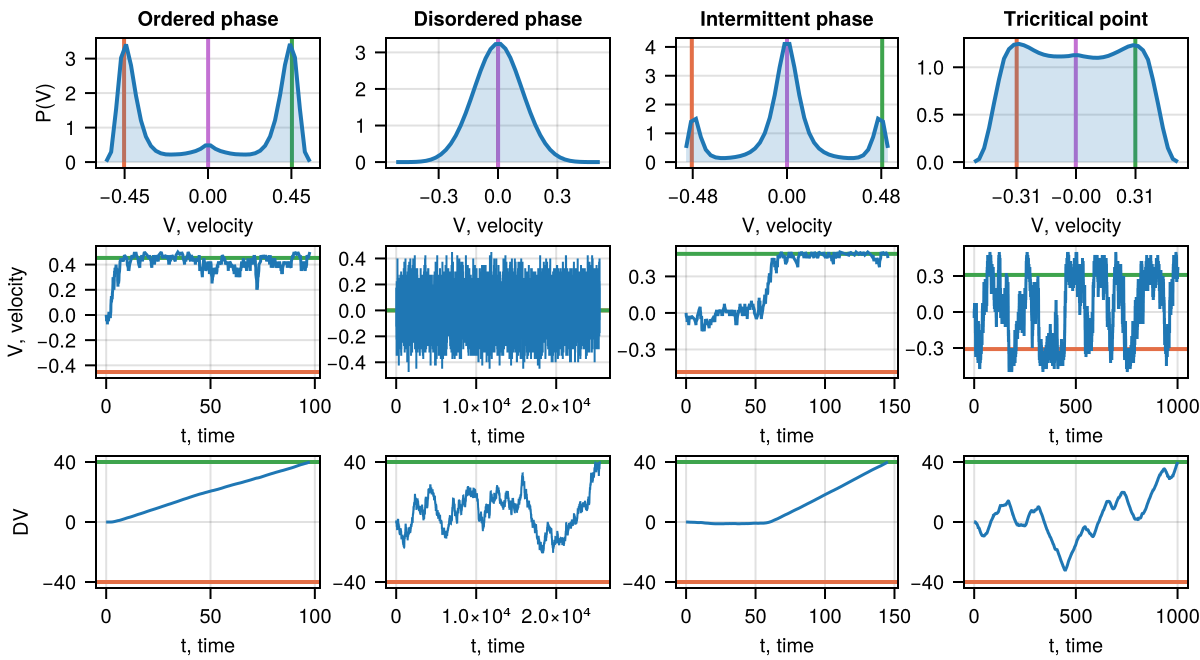

In [10]:
xvec, vvec, tvec = [], [], [];
fig = Figure(size=(150*4, 110*3), fontsize=10, figure_padding=(3, 6, 3, 3)); #400, 300
for (ind_phase, phase) in enumerate(phases)
    T, η = T_vec[ind_phase], η_vec[ind_phase];
    Vvec_severaltraj = Vvec_severaltraj_allphases[ind_phase];
    flag = -1;  x, v, t = [], [], [];
    while flag == -1
        x, v, t = DecisionTrajectory_xvt(T, η, ϵk, L, numSpins, dLcrossed=dLcrossed);
        flag = sign(x[end]);
    end
    push!(xvec, x); push!(vvec, v); push!(tvec, t);
    begin ax = []; #400, 300 
        push!(ax, Axis(fig[1, ind_phase], xlabel="V, velocity", ylabel= ind_phase!=1 ? "" : "P(V)",        title="$(phase)"));  
        push!(ax, Axis(fig[2, ind_phase], xlabel="t, time",     ylabel= ind_phase!=1 ? "" : "V, velocity", title=""));  
        push!(ax, Axis(fig[3, ind_phase], xlabel="t, time",     ylabel= ind_phase!=1 ? "" : "DV",          title=""));

        vlines!( ax[1], [VMF_pos(T, η, ϵ1), VMF_neg(T, η, ϵ1), mean(Vvec_severaltraj)], color=[c[2], c[3], c[4]], linewidth=2)
        hlines!(ax[2], [VMF_neg(T, η, ϵ1), VMF_pos(T, η, ϵ1),], color=[c[3], c[2]], linewidth=2)
        hlines!(ax[3], [L, -L], color=[c[2], c[3]], linewidth=2);

        density!(ax[1], Vvec_severaltraj, npoints = 42, color = (c[1], 0.2), strokecolor=c[1], strokewidth=2)
        lines!( ax[2], tvec[ind_phase], vvec[ind_phase], color=c[1], linewidth=phase=="Disordered phase" ? 1 : 1.5);
        lines!( ax[3], tvec[ind_phase], xvec[ind_phase], color=c[1], linewidth=phase=="Disordered phase" ? 1 : 1.5);
        if ind_phase != 2   
            ax[1].xticks = round.([VMF_pos(T, η, ϵ1), VMF_neg(T, η, ϵ1), mean(Vvec_severaltraj)], digits=2)  
        end
        #ax[2].xticks = round.([vel_mean_field_neg, vel_mean_field_pos, 0], digits=2)
        ax[3].yticks = [-L, 0, L];
    end
end
colgap!(fig.layout, 4); rowgap!(fig.layout, 6);
fig